# Потехин Сергей, 154

1. Загрузите данные из globalterrorismdb_0718dist.xlsx

2. Создайте графы G1 и G2 за 2 разных года (вершиной является eventid, списком смежности related;
года должны быть не обязательно последовательными, но не ранее 2000 года)

3. Удалите из графов изолированные вершины и мультиребра

4. Посчитайте для графов G1 и G2 graph edit distance (https://en.wikipedia.org/wiki/Graph_edit_distance).
Сделайте вывод о полученном "расстоянии" (3 балла)

5. Посчитайте ключевые метрики для каждого графа: diameter, eccentricity, periphery, girth, expansion.
Сделайте вывод о схожести графов (по 0.2 балла за каждую метрику)

6. Посчитайте Wiener_index для каждого графа (https://en.wikipedia.org/wiki/Wiener_index). Сделайте вывод о схожести графов (2 балла)

7. Посчитайте Hosoya_index для каждого графа (https://en.wikipedia.org/wiki/Hosoya_index). Сделайте вывод о схожести графов (2 балла)

8. Для каждого графа найдите ядро. Сделайте вывод о схожести графов (2 балла)

# Для вывода о схожести графов в пп. 5-8 придумайте какую-нибудь метрику,
вычисляющую "расстояние" между графами на основе полученных значений
индекса/характеристики (и обоснуйте, почему ваша метрика рациональна,
т.е. реально отражает схожесть графов в рамках данных расчетных индексов/характеристик)

# Формат выполнения задания:
- код на Python (приоритетно), R (менее приоритетно), Java (наименее приоритетно), C++ (совсем нежелательно)
- код необходимо выложить в личный репозиторий (GitHub, BitBucket)
- ссылку на репозиторий необходимо отправить мне в Telegram (@CroCode)
- дедлайн выполнения задания: 20 декабря (четверг), 08:59 утра

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

## Загрузка графа

In [2]:
data = pd.read_csv('terramorph.csv', low_memory=False)[65000:]

In [3]:
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
65000,199703220020,1997,3,22,NaN,0,NaN,186,Sri Lanka,6,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
65001,199703220022,1997,3,22,NaN,0,NaN,209,Turkey,10,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN
65002,199703230001,1997,3,23,NaN,0,NaN,92,India,6,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
65003,199703230002,1997,3,23,NaN,0,NaN,93,Indonesia,5,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
65004,199703230003,1997,3,23,NaN,0,NaN,159,Peru,3,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,0,-9,NaN


## Обработка данных

In [4]:
processed = {
    'first' : {},
    'second': {},
}

# Filtering
# - Only conneceted ones
not_null = (pd.isnull(data.related) == False)
# - Only 2007 year
first_year = (data.iyear == 2006)
second_year = (data.iyear == 2007)
# - Loading value
processed['first']['data'] = data.loc[first_year & not_null]
processed['second']['data'] = data.loc[second_year & not_null]

In [5]:
from random import choice
from random import randint
import re

# Getting the list of edges, from the 'related' attribute
def get_edges_to_add(D):
#     ids = dict(zip(D.eventid, list(range(len(D.eventid)))))
    ids = dict(zip(D.eventid, [hash(i) for i in D.eventid]))

    for r in D.iterrows():
        E = list(map(int, r[1]['related'].split(',')))
#         E = re.findall('\d+', r[1]['related'])
        for e in E:
            yield [
                ids[r[1].eventid],
                ids[int(e)]
            ]
            
# Out of the box, the graph will be pretty sparsed
# So it's a good idea to manually connect some connected components
def get_nodes_to_connect(D, sample_size=10):
    components = sorted(
        nx.connected_components(D),
        key=lambda x: -len(x),
    )
    components = list(map(list, components))

    first, second = randint(0, sample_size), randint(0, sample_size)

    return [
        choice(components[first]),
        choice(components[second])
    ]


# Creating networkx graphs
NODES_TO_CONNECT_MANUALLY = 10

# - First one
processed['first']['graph'] = nx.Graph()
processed['first']['graph'].add_nodes_from(range(processed['first']['data'].shape[0]))
edges = get_edges_to_add(processed['first']['data'])
for edge_from, edge_to in edges:
    processed['first']['graph'].add_edge(edge_from, edge_to)

for i in range(NODES_TO_CONNECT_MANUALLY):
    edge_from, edge_to = get_nodes_to_connect(processed['first']['graph'])
    processed['first']['graph'].add_edge(edge_from, edge_to)

# - Second one
processed['second']['graph'] = nx.Graph()
processed['second']['graph'].add_nodes_from(range(processed['second']['data'].shape[0]))
edges = get_edges_to_add(processed['second']['data'])
for edge_from, edge_to in edges:
    processed['second']['graph'].add_edge(edge_from, edge_to)

for i in range(NODES_TO_CONNECT_MANUALLY):
    edge_from, edge_to = get_nodes_to_connect(processed['second']['graph'])
    processed['second']['graph'].add_edge(edge_from, edge_to)

## Визуализация

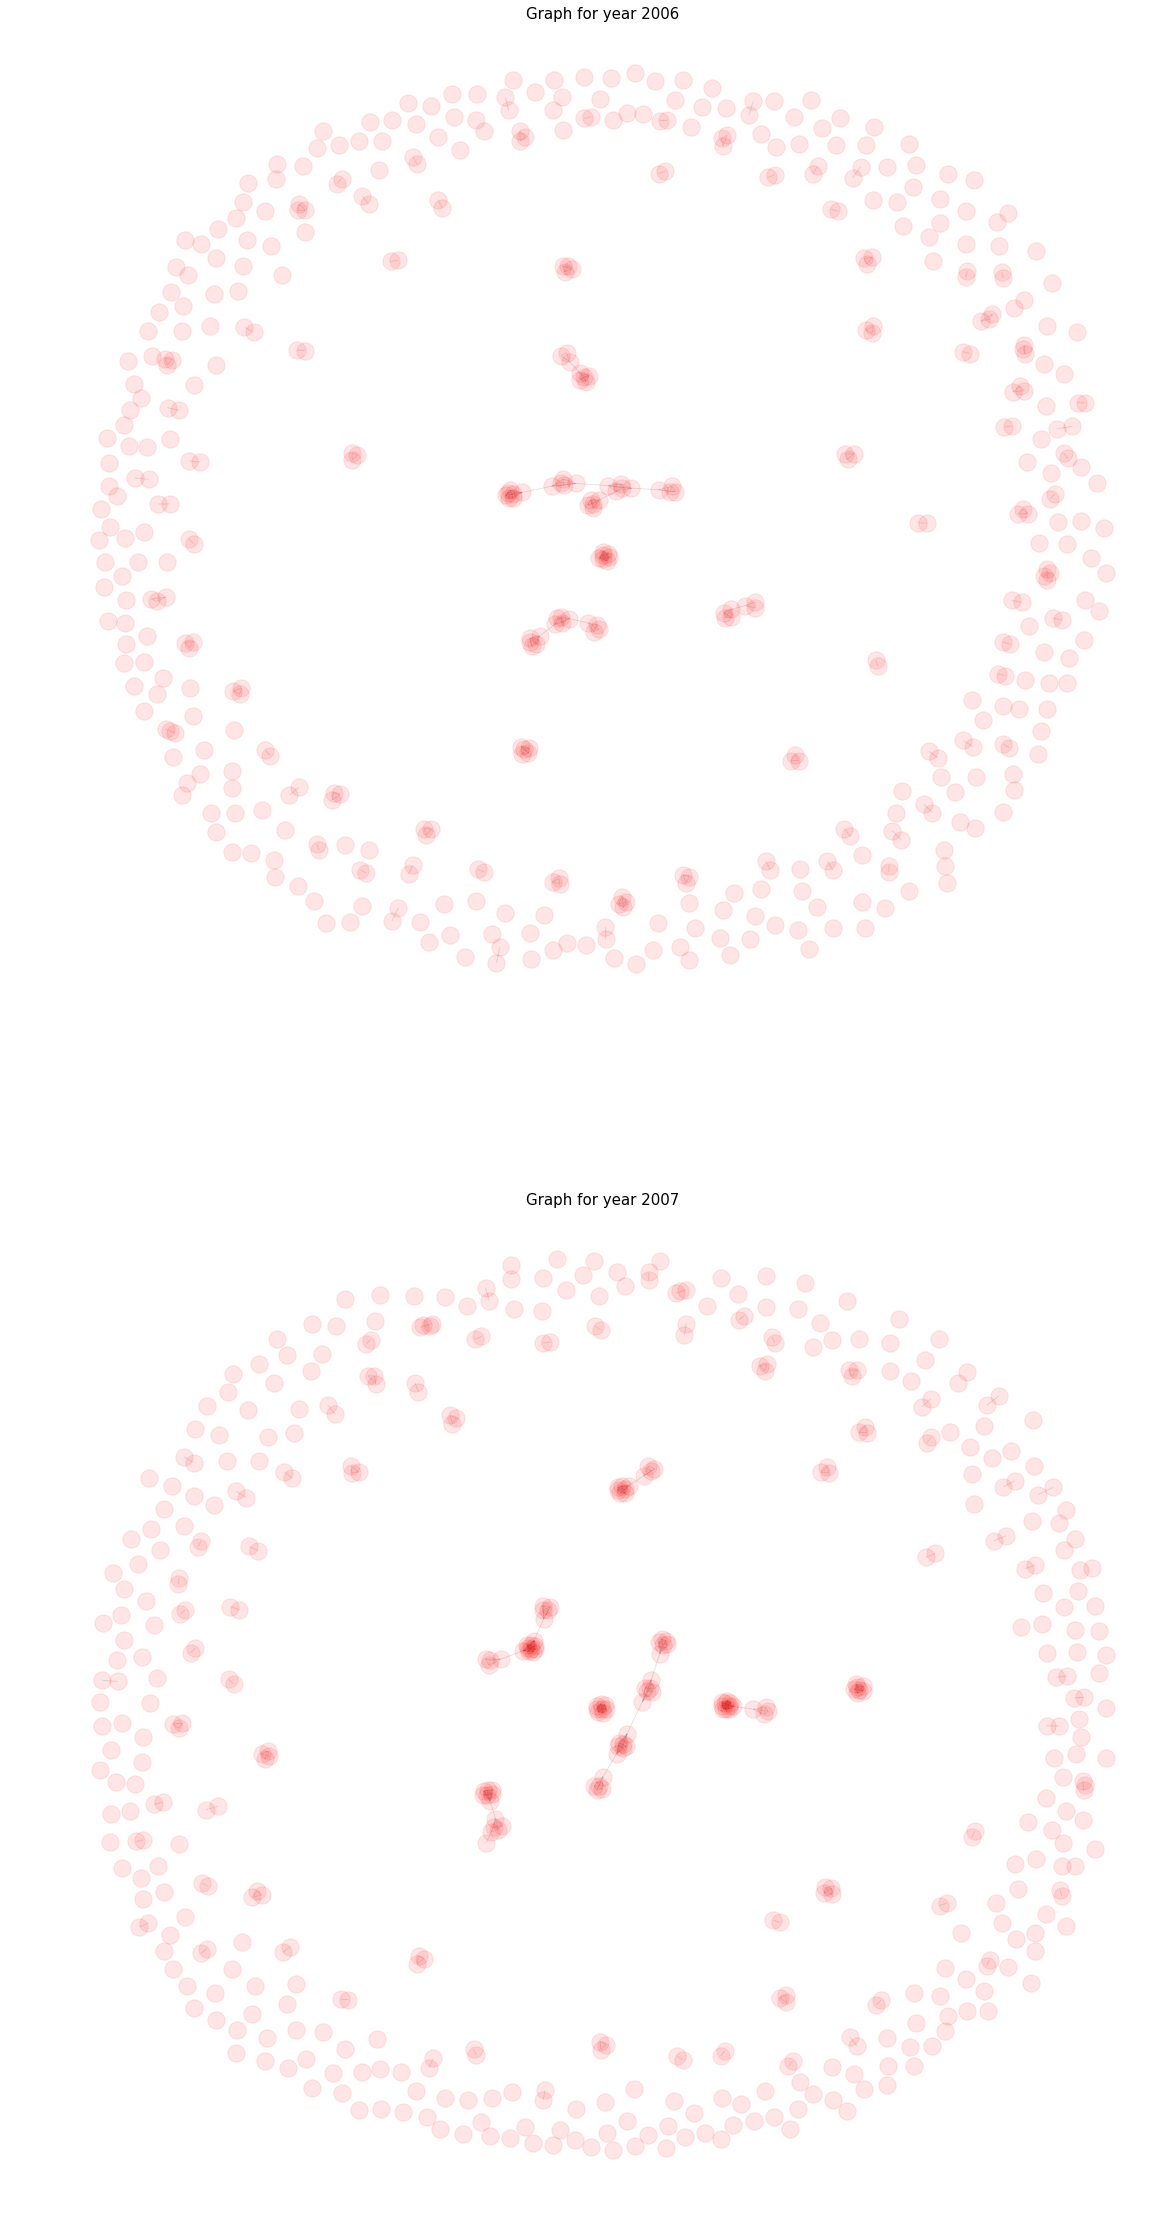

In [6]:
f = plt.figure(figsize=(20,40))

ax = f.subplots(nrows=2, ncols=1)

pos = nx.spring_layout(processed['first']['graph'])
nx.draw_networkx(processed['first']['graph'], alpha=0.1, node_size=300, with_labels=False, ax=ax[0])
ax[0].axis('off')
ax[0].set_title('Graph for year 2006', fontsize=15)

pos = nx.spring_layout(processed['second']['graph'])
nx.draw_networkx(processed['second']['graph'], alpha=0.1, node_size=300, with_labels=False, ax=ax[1])
ax[1].axis('off')
ax[1].set_title('Graph for year 2007', fontsize=15)

plt.show()

## Подсчет GED (Graph Edit Distance)

In [7]:
# Distance between edges
def distance_between_edges(
        first_graph,
        second_graph,
        first_node,
        second_node
    ):

    first_edges, second_edges = list(first_graph.edges(first_node)), list(second_graph.edges(second_node))
    
    if len(first_edges) == 0:
        return max(len(first_edges), len(second_edges))

    if len(second_edges) == 0:
        return max(len(first_edges), len(second_edges))

    new_first_graph, new_second_graph = nx.Graph(), nx.Graph()

    new_first_graph.add_nodes_from(first_edges)
    new_second_graph.add_nodes_from(second_edges)

    return GED(
        first_graph=new_first_graph,
        second_graph=new_second_graph,
        is_graph=False,
        initial=False
    )

# Cost for the substitution
def cost(
        first_graph,
        second_graph,
        first_node,
        second_node,
        is_graph=True
    ):

    if not is_graph:
        return equal_or_not(first_node, second_node, 0, 1)

    ed = distance_between_edges(
        first_graph=first_graph,
        second_graph=second_graph,
        first_node=first_node,
        second_node=second_node
    )

    return equal_or_not(first_node, second_node, 0, 1) + ed

In [8]:
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm_notebook

BIG_INT = 2**64

# Return 'correct' is i is equal to j, return 'r' otherwise
def equal_or_not(i,j,correct=1,r=BIG_INT):
    if i == j:
        return correct
    return r

# Show progress bar only for entry-call and skip others
def tqdm_only_initial(R, initial):
    if initial:
        return tqdm_notebook(R)
    return R

# Graph Edit Distance entry point
def GED(first_graph, second_graph, is_graph=True, initial=False):
    first_nodes, second_nodes = list(first_graph.nodes), list(second_graph.nodes)
    n, m = len(first_nodes), len(second_nodes)
    M = np.zeros((n + m, n + m))

    for i in tqdm_only_initial(xrange(m), initial):
        for j in xrange(m): M[i + n, j] = equal_or_not(i,j)
            
    for i in tqdm_only_initial(xrange(n), initial):
        for j in xrange(n): M[j, i + m] = equal_or_not(i,j)

    for i in tqdm_only_initial(xrange(n), initial):
        for j in xrange(m):
            f, s = first_nodes[i], second_nodes[j]

            M[i, j] = cost(
                first_graph=first_graph,
                second_graph=second_graph,
                first_node=f,
                second_node=s,
                is_graph=is_graph
            )
            
    f, s = linear_sum_assignment(M)

    r = 0
    for i in xrange(len(f)):
        r += M[f[i]][s[i]]

    return r

print ("Graph Edit Distance:")
print (GED(
    processed['first']['graph'],
    processed['second']['graph'],
    initial=True,
))


Graph Edit Distance:



508.0


### Вывод о GED

## Подсчет метрик по каждому графу
### Diameter

In [9]:
NOT_MAX_INT = 2**30

def diameter(M):
    M_ = M.copy()
    M_[np.where(M_ == 0)] = NOT_MAX_INT
    M_size = len(M)

    for i in tqdm_only_initial(xrange(M_size), initial=True):
        M_[i, i] = 0 # Set up diagonal equal to 0

    for k in tqdm_only_initial(xrange(M_size), initial=True):
        for i in xrange(M_size):
            for j in xrange(M_size):
                M_[i, j] = min(
                    M_[i, k] + M_[k, j],
                    M_[i, j],
                )

    not_max = M_[np.where(M_ != NOT_MAX_INT)]
    return M_, np.max(not_max)

In [ ]:
r = diameter(nx.adjacency_matrix(processed['first']['graph']).todense())
processed['first']['all_paths'] = r[0]
processed['first']['diameter'] = r[1]

print ('Diameter for first graph equal to')
print (processed['first']['diameter'])

In [ ]:
r = diameter(nx.adjacency_matrix(processed['second']['graph']).todense())
processed['second']['all_paths'] = r[0]
processed['second']['diameter'] = r[1]

print ('Diameter for second graph equal to')
print (processed['second']['diameter'])

### Eccentricity

In [ ]:
def eccentricity(P_):
    not_max = np.where(P_ == NOT_MAX_INT)
    P_[not_max] = -1
    m = np.max(P_, axis=0)
    r = np.array(m)[0]

    return r

In [ ]:
print ('Eccentricity for all nodes in a first graph')
print (",".join(map(str, eccentricity(processed['first']['all_paths']))))

In [ ]:
print ('Eccentricity for all nodes in a second graph')
print (",".join(map(str, eccentricity(processed['second']['all_paths']))))

### Periphery

In [ ]:
def periphery(D, P):
    equals = (eccentricity(P) == D)
    return np.where(equals)[0]

In [ ]:
print ('Periphery nodes for the first graph')
print (",".join(map(str, periphery(
    D=processed['first']['diameter'],
    P=processed['first']['all_paths']
))))

In [ ]:
print ('Periphery nodes for the second graph')
print (",".join(map(str, periphery(
    D=processed['second']['diameter'],
    P=processed['second']['all_paths']
))))

### Girth

In [ ]:
# :C

### Expansion

In [ ]:
# :C

## Подсчет Wiener index

In [ ]:
def wiener(P):
    for i in range(len(P) - 1):
        tsm = np.where(P[i, i + 1:] == 1)
        yield len(tsm[0])

In [ ]:
print ('Weiner index for the first graph')
print (sum(wiener(processed['first']['all_paths'])))

In [ ]:
print ('Weiner index for the second graph')
print (sum(wiener(processed['second']['all_paths'])))